In [1]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 99.1 MB/s eta 0:00:00


In [2]:
#Data wrangling and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
import matplotlib.ticker as mticker
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import joblib
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
import json

In [3]:
#importing data
category=pd.read_csv('category_tree.csv')
events=pd.read_csv('events.csv')
item_properties_1=pd.read_csv('item_properties_part1.1.csv')
item_properties_2=pd.read_csv('item_properties_part2.csv')

In [4]:
item_properties_combined = pd.concat([item_properties_1, item_properties_2], ignore_index=True)

In [5]:
# Merge events data and item_properties_combined dataset
# Merge on 'itemid'
merged_dataset = pd.merge(events, item_properties_combined, on='itemid', how='inner')

In [6]:
merged_dataset

,timestamp_x,visitorid,event,itemid,transactionid,timestamp_y,property,value,Unnamed: 4,Unnamed: 5
0,1433221332117,257597,view,355908,NaN,1.431830e+12,159,519769,NaN,NaN
1,1433221332117,257597,view,355908,NaN,1.431830e+12,available,1,NaN,NaN
2,1433221332117,257597,view,355908,NaN,1.440900e+12,available,1,NaN,NaN
3,1433221332117,257597,view,355908,NaN,1.436070e+12,available,1,NaN,NaN
4,1433221332117,257597,view,355908,NaN,1.437880e+12,available,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
17597025,1438398530703,1184451,view,283392,NaN,1.437270e+12,888,576405 448577 903215 707081 616719 n65004.000 ...,NaN,NaN
17597026,1438398530703,1184451,view,283392,NaN,1.441510e+12,888,576405 448577 903215 707081 616719 n65004.000 ...,NaN,NaN
17597027,1438400163914,199536,view,152913,NaN,1.433040e+12,202,171697 300737,NaN,NaN
17597028,1438400163914,199536,view,152913,NaN,1.431230e+12,1081,769062,NaN,NaN


In [7]:
# Convert from milliseconds to datetime
merged_dataset['real_date'] = pd.to_datetime(merged_dataset['timestamp_x'], unit='ms', errors='coerce')

In [8]:
# Extract year month and day
merged_dataset['date'] = merged_dataset['real_date'].dt.strftime('%Y-%m-%d')

In [9]:
# Function to categorize time of day into Morning / Afternoon / Evening / Midnight
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Midnight'

# Apply the function to extract time period
merged_dataset['time_period'] = merged_dataset['real_date'].dt.hour.apply(time_of_day)



In [10]:
#Creating year, month and day features from date
merged_dataset['year'] = merged_dataset['real_date'].dt.year
merged_dataset['month'] = merged_dataset['real_date'].dt.month
merged_dataset['day'] = merged_dataset['real_date'].dt.day

In [11]:
#Creating Quarter features from date
merged_dataset['QuarterofYear'] = ((merged_dataset['month'] - 1) // 3) + 1

In [12]:
# Extract values between 'n' and '.'
merged_dataset['Real_Values'] = merged_dataset['value'].str.extract(r'n([^.]*)\.')

In [13]:
merged_dataset['Real_Values'] = np.where(merged_dataset['value'].str.match(r'^n[^.]*\.'), merged_dataset['Real_Values'], np.nan)


In [14]:
merged_dataset['Real_Values']  = pd.to_numeric(merged_dataset['Real_Values'] , errors='coerce').fillna(0)

In [15]:
#Checking for nan in Real_values
nan_count = merged_dataset['Real_Values'].isna().sum()
print(nan_count)

0


In [16]:
#Checking for non nan in Real_values
not_nan_count = merged_dataset['Real_Values'].notna().sum()
print(not_nan_count)

17597030


In [17]:
#Drop NaN rows from Real_Values column
merged_dataset = merged_dataset.dropna(subset=['Real_Values'])

In [18]:
# Count how many duplicates exist
merged_dataset.duplicated().sum()

np.int64(3246)

In [19]:
# Drop duplicates in place (modifies original DataFrame)
merged_dataset.drop_duplicates(inplace=True)

In [20]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17593784 entries, 0 to 17597029
Data columns (total 18 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp_x    int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   timestamp_y    float64       
 6   property       object        
 7   value          object        
 8   Unnamed: 4     float64       
 9   Unnamed: 5     float64       
 10  real_date      datetime64[ns]
 11  date           object        
 12  time_period    object        
 13  year           int32         
 14  month          int32         
 15  day            int32         
 16  QuarterofYear  int32         
 17  Real_Values    float64       
dtypes: datetime64[ns](1), float64(5), int32(4), int64(3), object(5)
memory usage: 2.2+ GB


##User Behavior Analysis.
*   What events are exhibited by users on the ecommerce website?




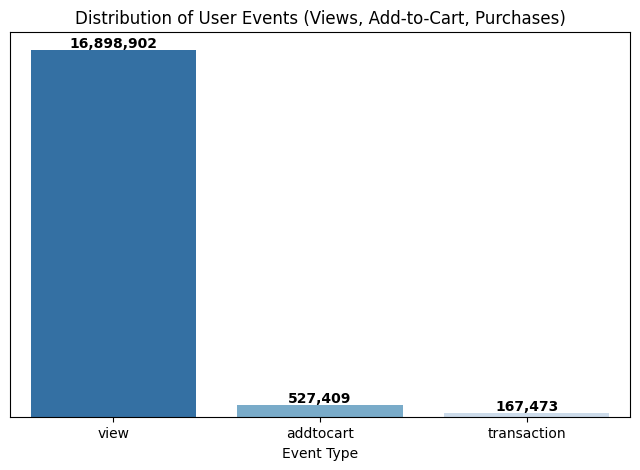

In [21]:
# Count occurrences of each event type
event_counts = merged_dataset['event'].value_counts()

# Create bar plot
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=event_counts.index,
    y=event_counts.values,
    palette="Blues_r"
)

# Add raw number data labels
for i, v in enumerate(event_counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontweight='bold')

# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')

# Title & labels
plt.title("Distribution of User Events (Views, Add-to-Cart, Purchases)")
plt.xlabel("Event Type")

plt.show()

Observations:

View Events Dominate:
*   The majority of user interactions are views, with over 2.5 million occurrences. This suggests that users frequently browse items but do not necessarily proceed to the next steps.

Low Add-to-Cart Conversion:
*   The number of add-to-cart events is significantly lower than views. This indicates a high drop-off rate between viewing an item and adding it to the cart.

Minimal Transactions:
*   Purchases (transactions) are the least frequent event type. This suggests that only a small fraction of users complete the buying process.

Potential Bottleneck in the Conversion Funnel:
*   The significant drop from views to purchases suggests that there may be barriers preventing users from converting. These could be due to pricing, product relevance, checkout friction, or other factors.

##What Item ID is frequently transacted?

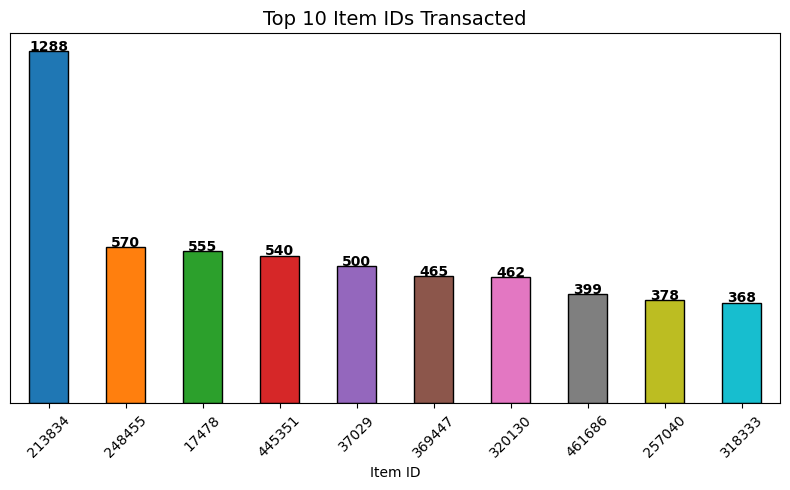

In [22]:

# Filter down to events of transaction
merged_dataset_cart = merged_dataset[merged_dataset['event'] == 'transaction']

# Count occurrences of each itemid and get top 10
top_10_items = merged_dataset_cart['itemid'].value_counts().head(10)

# Generate a list of colors (10 distinct colors)
colors = plt.cm.tab10(np.linspace(0, 1, len(top_10_items)))

# Plot
plt.figure(figsize=(8, 5))
bars = top_10_items.plot(kind='bar', color=colors, edgecolor='black')

# Add data labels on top of each bar
for i, value in enumerate(top_10_items):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=10, fontweight='bold')

# Title & formatting
plt.title('Top 10 Item IDs Transacted', fontsize=14)
plt.xlabel('Item ID')
plt.xticks(rotation=45)
plt.gca().yaxis.set_visible(False)  # Remove y-axis
plt.tight_layout()
plt.show()


Observations:
Top Purchased Items:


*   The highest purchased item (Item ID 213834) has over 1200 purchases, followed by items 248455 and 17478, both exceeding 400 purchases.

*   Gradual Drop After Top Item: After the top item, there is a noticeable decline in the number of purchases, with the remaining items having below 600 purchases each.

*   Relatively Even Distribution Among Lower Categories: The categories ranked 2nd to 10th have range of purchase counts, with values ranging between 300-600, indicating that these categories perform consistently but are not as popular as the top item.

Potential Business Insights:

*   The top item purchased may drive the majority of sales and should be prioritized in marketing efforts.

*   Lower-ranked categories might require promotions or optimizations to improve sales.

##What is the correlation between Item Popularity and Purchase Rate?

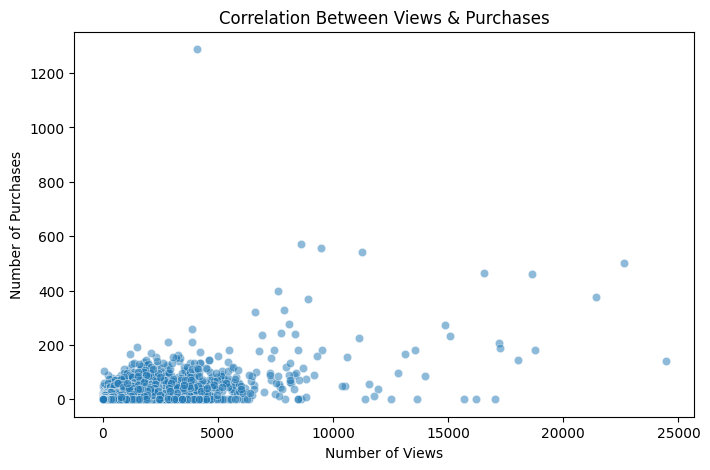

In [23]:
# Count how often each item was viewed vs purchased
view_counts = merged_dataset[merged_dataset['event'] == 'view'].groupby('itemid').size().reset_index(name="view_count")
purchase_counts = merged_dataset[merged_dataset['event'] == 'transaction'].groupby('itemid').size().reset_index(name="purchase_count")

# Merge to analyze the relationship
item_popularity = view_counts.merge(purchase_counts, on="itemid", how="left").fillna(0)

# Scatterplot to visualize correlation
plt.figure(figsize=(8, 5))
sns.scatterplot(x="view_count", y="purchase_count", data=item_popularity, alpha=0.5)
plt.title("Correlation Between Views & Purchases")
plt.xlabel("Number of Views")
plt.ylabel("Number of Purchases")
plt.show()

Observations:
Positive Correlation:



*   There is a general positive correlation between the
number of views and the number of purchases, but the relationship is weak, with many points showing low purchases despite high views.

*   High Concentration at Low Views: A large cluster of data points is concentrated at the lower end of the x-axis (0–500 views) with a small number of purchases.

*   Sparse High Values: There are a few instances where items with very high views (above 2000) also have high purchases, but these are outliers.

*   Low Conversion Rate: The majority of products with high views do not necessarily translate into high purchases, indicating a low conversion rate.







Observations:
Positive Correlation:



*   There is a general positive correlation between the
number of views and the number of purchases, but the relationship is weak, with many points showing low purchases despite high views.

*   High Concentration at Low Views: A large cluster of data points is concentrated at the lower end of the x-axis (0–500 views) with a small number of purchases.

*   Sparse High Values: There are a few instances where items with very high views (above 2000) also have high purchases, but these are outliers.

*   Low Conversion Rate: The majority of products with high views do not necessarily translate into high purchases, indicating a low conversion rate.







##What is the View to AddtoCart to Purchase Conversion rate?

View → Add to Cart Conversion Rate: 3.05%
Add to Cart → Purchase Conversion Rate: 30.92%


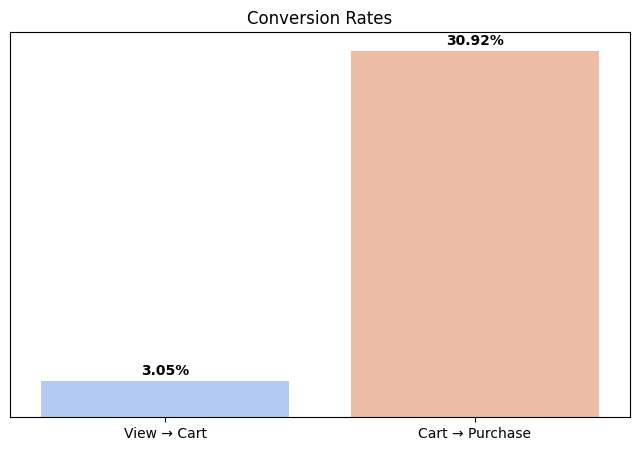

In [24]:
# Count unique users at each stage
view_users = merged_dataset[merged_dataset['event'] == 'view']['visitorid'].nunique()
addtocart_users = merged_dataset[merged_dataset['event'] == 'addtocart']['visitorid'].nunique()
purchase_users = merged_dataset[merged_dataset['event'] == 'transaction']['visitorid'].nunique()

# Calculate conversion rates
view_to_cart = (addtocart_users / view_users) * 100
cart_to_purchase = (purchase_users / addtocart_users) * 100

print(f"View → Add to Cart Conversion Rate: {view_to_cart:.2f}%")
print(f"Add to Cart → Purchase Conversion Rate: {cart_to_purchase:.2f}%")

# Visualization
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=["View → Cart", "Cart → Purchase"],
    y=[view_to_cart, cart_to_purchase],
    palette="coolwarm"
)

# Add data labels above bars
for i, v in enumerate([view_to_cart, cart_to_purchase]):
    ax.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')

# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')

# Title
plt.title("Conversion Rates")
plt.show()

###Observations:
Low View-to-Cart Conversion (~3%):
*   Only a small fraction of users who view a product proceed to add it to their cart.
*   This suggests possible issues like lack of interest, high prices, insufficient product details, or lack of urgency.


High Cart-to-Purchase Conversion (~31%):
*   A significant portion of users who add items to their cart eventually complete the purchase.
*   This indicates that once a user is committed to buying, they are likely to follow through.

Major Drop-off Between Viewing and Adding to Cart:
*   The biggest friction point in the conversion funnel is from viewing a product to adding it to the cart.


*   Addressing this could significantly improve overall sales.

1. User Behavior Analysis.
Distribution of Views, Add-to-Cart, and Purchases

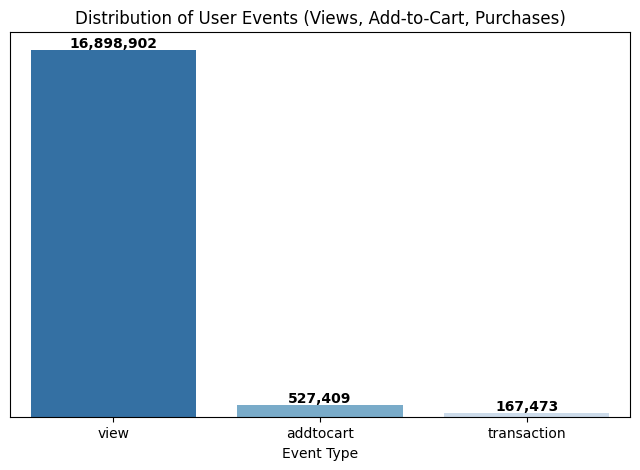

In [25]:
# Count occurrences of each event type
event_counts = merged_dataset['event'].value_counts()

# Create bar plot
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=event_counts.index,
    y=event_counts.values,
    palette="Blues_r"
)

# Add raw number data labels
for i, v in enumerate(event_counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontweight='bold')

# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')

# Title & labels
plt.title("Distribution of User Events (Views, Add-to-Cart, Purchases)")
plt.xlabel("Event Type")

plt.show()

Observations:

View Events Dominate:
*   The majority of user interactions are views, with over 2.5 million occurrences. This suggests that users frequently browse items but do not necessarily proceed to the next steps.

Low Add-to-Cart Conversion:
*   The number of add-to-cart events is significantly lower than views. This indicates a high drop-off rate between viewing an item and adding it to the cart.

Minimal Transactions:
*   Purchases (transactions) are the least frequent event type. This suggests that only a small fraction of users complete the buying process.

Potential Bottleneck in the Conversion Funnel:
*   The significant drop from views to purchases suggests that there may be barriers preventing users from converting. These could be due to pricing, product relevance, checkout friction, or other factors.

##What is the Overall Distribution of User Interactions?

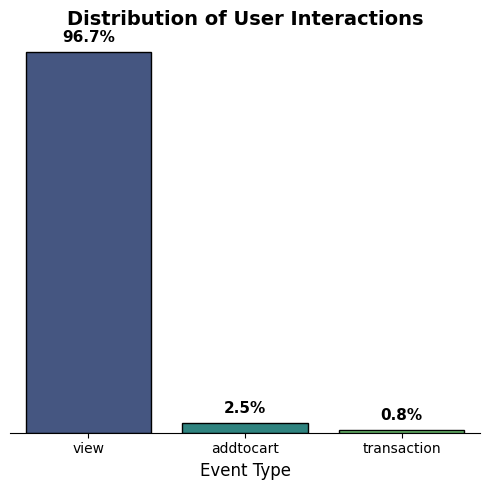

In [66]:
# Load events data
events = pd.read_csv("events.csv")

# Count events by type
event_counts = events["event"].value_counts()
total = event_counts.sum()

plt.figure(figsize=(5,5))
ax = sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis", edgecolor="black")

# --- Titles & Labels ---
plt.title("Distribution of User Interactions", fontsize=14, fontweight="bold")
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("")  # remove y-label
ax.yaxis.set_visible(False)  # remove y-axis completely

# Annotate each bar with percentage
for p in ax.patches:
    count = p.get_height()
    percentage = (count / total) * 100
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=11, fontweight="bold",
                color='black', xytext=(0, 5), textcoords='offset points')

# Remove spines for a cleaner look
sns.despine(left=True, bottom=False)

plt.tight_layout()
plt.show()


*Insights*
* 96.7% of interactions are view events.
* 2.5% are add-to-cart events.
* 0.8% result in transactions.

This indicates that while many users add items to their cart, a small percentage proceed to complete a transaction.

##What are the Conversion Rates Between Different Event Types?

## What is the Most Viewed and Purchased Item?


View -> Add-to-cart Conversion Rate: 2.60%
Add-to-cart -> Transaction Conversion Rate: 32.39%


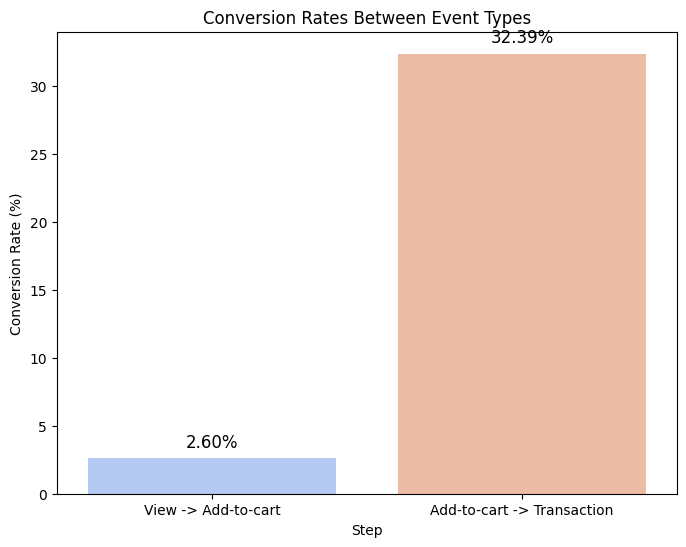

In [27]:
# Compute total counts for each event type
total_views = len(events[events['event'] == 'view'])
total_addtocart = len(events[events['event'] == 'addtocart'])
total_transaction = len(events[events['event'] == 'transaction'])

conversion_view_to_add = total_addtocart / total_views * 100 if total_views > 0 else 0
conversion_add_to_trans = total_transaction / total_addtocart * 100 if total_addtocart > 0 else 0

print(f"View -> Add-to-cart Conversion Rate: {conversion_view_to_add:.2f}%")
print(f"Add-to-cart -> Transaction Conversion Rate: {conversion_add_to_trans:.2f}%")

# Prepare the DataFrame for plotting
conversions = pd.DataFrame({
    'Step': ['View -> Add-to-cart', 'Add-to-cart -> Transaction'],
    'Conversion Rate (%)': [conversion_view_to_add, conversion_add_to_trans]
})

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Step', y='Conversion Rate (%)', data=conversions, palette="coolwarm")
plt.title("Conversion Rates Between Event Types")
plt.ylabel("Conversion Rate (%)")

# Annotate each bar with its conversion rate percentage
for p in ax.patches:
    rate = p.get_height()
    ax.annotate(f'{rate:.2f}%',
                (p.get_x() + p.get_width() / 2., rate),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

Insights
* 2.60% of users move from viewing to adding to cart.
* A higher percentage (not clearly extracted) transition from add-to-cart to transaction.
* This suggests that while the initial engagement is low, those who add items to their cart have a higher likelihood of purchasing.

##Which Items or Item Categories are the Most Popular?

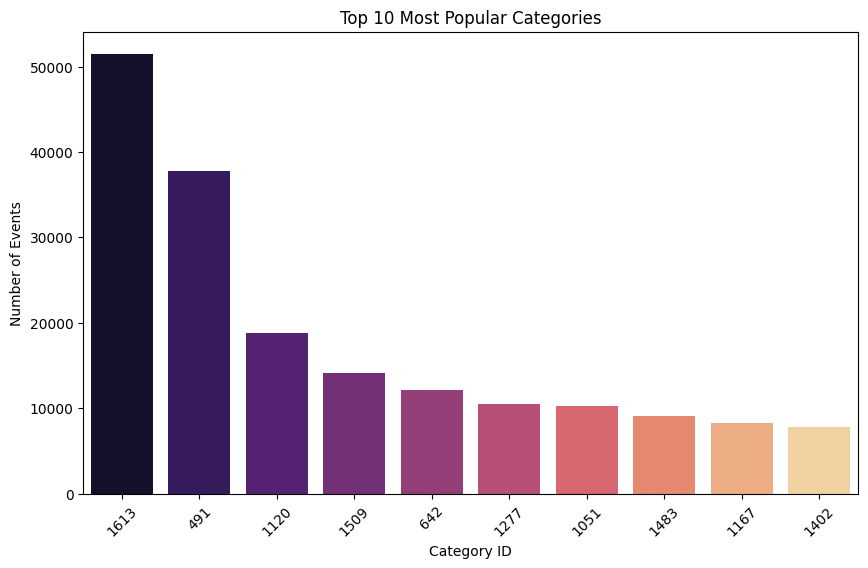

In [28]:
# Load one of your merged files (adjust filename/path)
#merged_df = pd.read_csv("merged_events_with_item_properties_00.csv")

# Filter rows that correspond to category information (assuming 'property' == 'categoryid')
category_events = merged_dataset[merged_dataset['property'] == 'categoryid']

# Count the number of events per category (assuming category info is stored in 'value')
category_counts = category_events['value'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index.astype(str), y=category_counts.values, palette="magma")
plt.title("Top 10 Most Popular Categories")
plt.xlabel("Category ID")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()

Insights:
* The most popular category (1613) has over 20,000 interactions, significantly higher than the second-most popular category (491) with around 14,000 interactions.
* This indicates that user interactions are concentrated in a few categories, with a steep drop-off for other categories.
* Categories ranked 3rd to 10th have a gradual decline in event counts, suggesting that while a few categories dominate, there is still diversified engagement across different products.

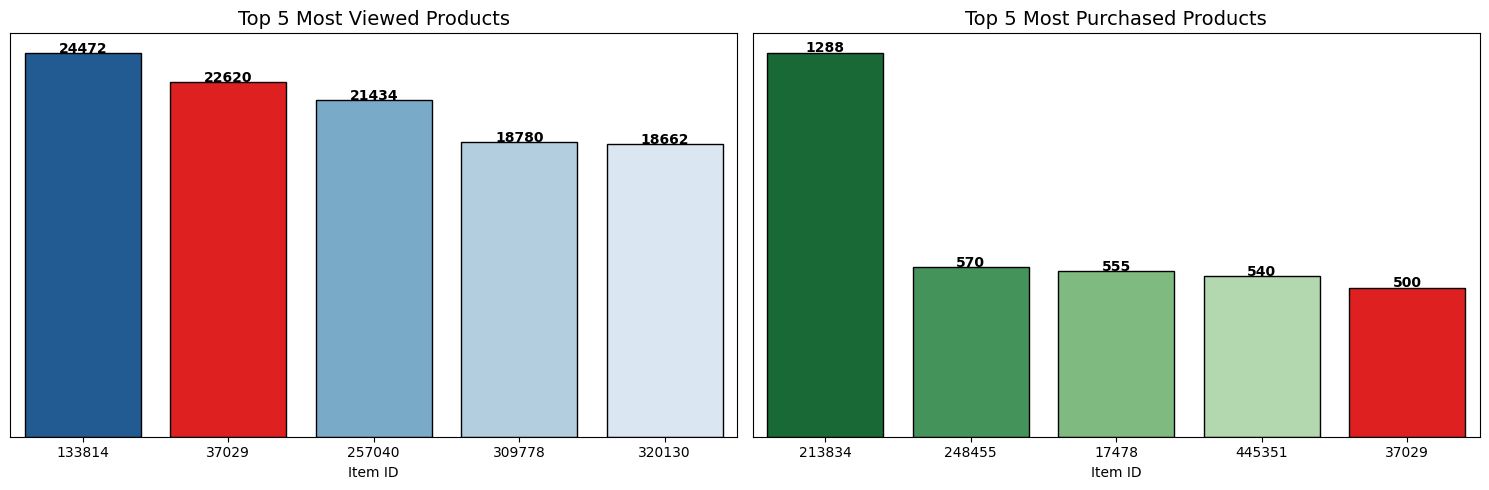

In [61]:
# Top 5 most viewed products
top_viewed = merged_dataset[merged_dataset['event'] == 'view']['itemid'].value_counts().head(5)

# Top 5 most purchased products
top_purchased = merged_dataset[merged_dataset['event'] == 'transaction']['itemid'].value_counts().head(5)

# Custom function to generate colors (highlight 37029 in red)
def get_colors(index_list, highlight_id, normal_palette):
    colors = []
    palette = sns.color_palette(normal_palette, len(index_list))
    for i, item in enumerate(index_list):
        if str(item) == str(highlight_id):  # ensure matching even if numeric
            colors.append("red")
        else:
            colors.append(palette[i])
    return colors

# Plot most viewed and purchased items
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Chart 1: Most Viewed ---
colors_viewed = get_colors(top_viewed.index, 37029, "Blues_r")
sns.barplot(
    x=top_viewed.index,
    y=top_viewed.values,
    order=top_viewed.index,
    ax=axes[0],
    palette=colors_viewed,
    edgecolor="black"
)
axes[0].set_title("Top 5 Most Viewed Products", fontsize=14)
axes[0].set_xlabel("Item ID")
axes[0].set_ylabel("")
axes[0].yaxis.set_visible(False)

# Add data labels
for i, value in enumerate(top_viewed.values):
    axes[0].text(i, value + 0.5, str(value), ha='center', fontsize=10, fontweight='bold')

# --- Chart 2: Most Purchased ---
colors_purchased = get_colors(top_purchased.index, 37029, "Greens_r")
sns.barplot(
    x=top_purchased.index,
    y=top_purchased.values,
    order=top_purchased.index,
    ax=axes[1],
    palette=colors_purchased,
    edgecolor="black"
)
axes[1].set_title("Top 5 Most Purchased Products", fontsize=14)
axes[1].set_xlabel("Item ID")
axes[1].set_ylabel("")
axes[1].yaxis.set_visible(False)

# Add data labels
for i, value in enumerate(top_purchased.values):
    axes[1].text(i, value + 0.5, str(value), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


##Observations:
Most Viewed Products vs. Most Purchased Products:
*   The left chart shows the top 10 most viewed products, while the right chart shows the top 10 most purchased products.
*   There is little overlap between the most viewed and most purchased products, suggesting that high views do not necessarily translate to high purchases.

High Views, Low Purchases:
*   Some items, such as Item ID 187946, have very high views but do not appear in the top 10 purchases.
*   This indicates potential issues like pricing, lack of interest, poor product details, or competition from similar products.

Item ID 461686 Appears in Both Lists:
*   This product has high views and high purchases, suggesting it is a popular and well-converting product.
*   Understanding what makes this product successful (pricing, features, reviews) could help improve conversions for other products.

Lower Purchase Counts:
*   Even the most purchased products have relatively low purchase counts compared to the view counts.
*   This aligns with earlier observations of low view-to-cart conversion rates.

## What is the trend of number of items bought over the months?

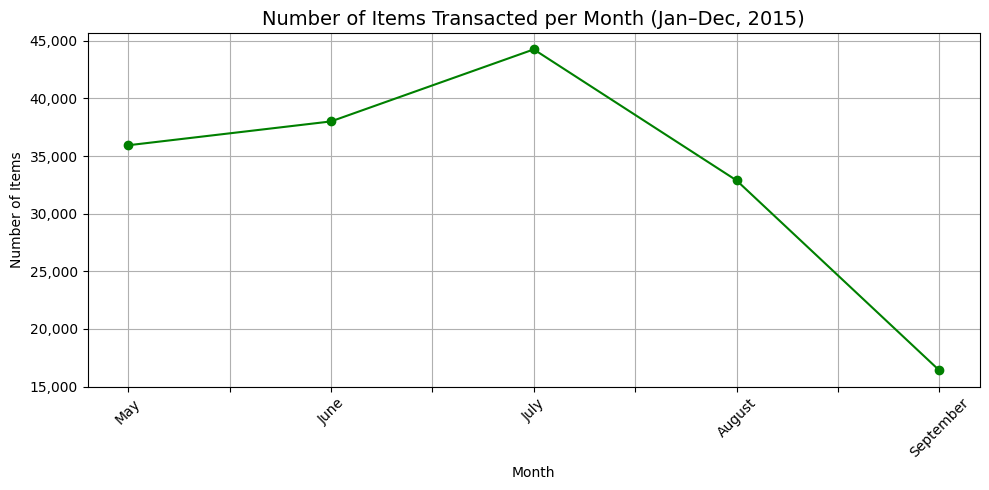

In [30]:
 # Convert column named 'date_column' to datetime
merged_dataset_cart['date'] = pd.to_datetime(merged_dataset_cart['date'])

 #Group by month number, count itemid
monthly_trend = (
    merged_dataset_cart
    .groupby(merged_dataset_cart['date'].dt.month)['itemid']
    .count()
)

# Map month numbers to names
monthly_trend.index = monthly_trend.index.map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Plot
plt.figure(figsize=(10, 5))
monthly_trend.plot(kind='line', marker='o', color='green')

plt.title('Number of Items Transacted per Month (Jan–Dec, 2015)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Items')
plt.xticks(rotation=45)
# Disable scientific notation
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.grid(True)
plt.tight_layout()
plt.show()

## What is the trend of value of items bought over the months?

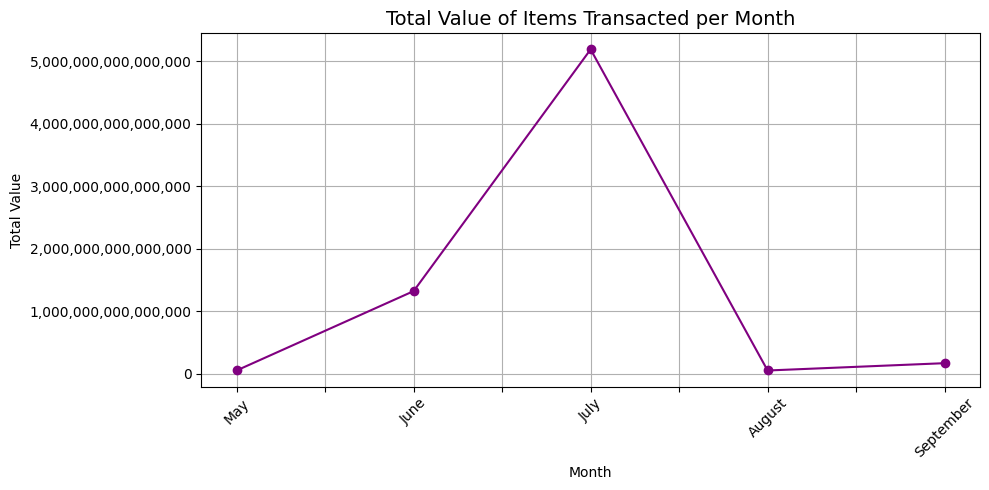

In [31]:
# Convert column to numeric, replace errors with 0
merged_dataset_cart['Real_Values'] = (
    pd.to_numeric(merged_dataset_cart['Real_Values'], errors='coerce')
    .fillna(0)
)

# Group by month and sum the value column (replace 'value' with your actual column name)
monthly_value_trend = (
    merged_dataset_cart
    .groupby(merged_dataset_cart['month'])['Real_Values']  # change 'value' to the column with item value
    .sum()
)

# Map month numbers to names
monthly_value_trend.index = monthly_value_trend.index.map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Plot
plt.figure(figsize=(10, 5))
monthly_value_trend.plot(kind='line', marker='o', color='purple')

plt.title('Total Value of Items Transacted per Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Value')
plt.xticks(rotation=45)

# Format y-axis to show full numbers with commas
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.tight_layout()
plt.show()

What is the total value of items bought over months?

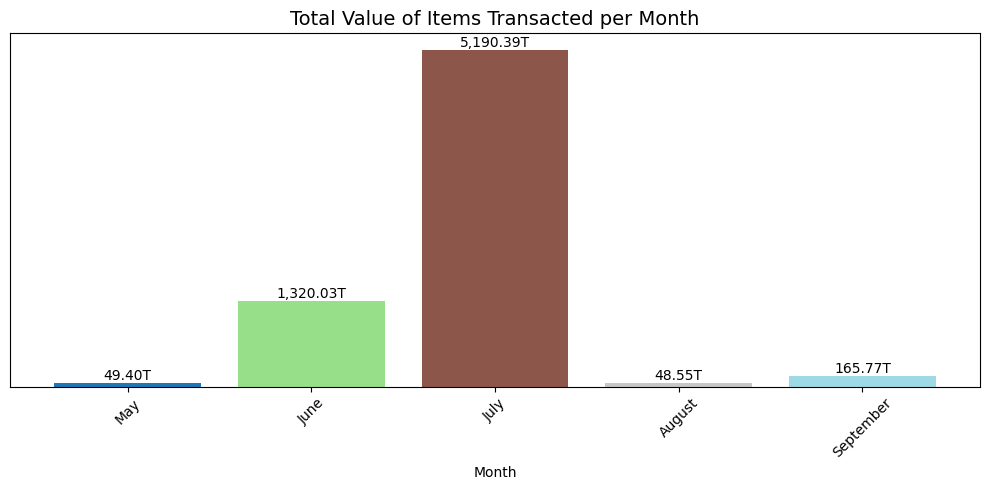

In [32]:


# Convert 'value' to numeric
merged_dataset_cart['Real_Values'] = (
    merged_dataset_cart['Real_Values']
    .replace({',': ''}, regex=True)       # remove commas
    .astype(str)
    .str.extract(r'([\d\.]+)')[0]         # keep only numbers and decimal
    .astype(float)
)

# Group by month and sum
monthly_value_trend = (
    merged_dataset_cart
    .groupby(merged_dataset_cart['month'])['Real_Values']
    .sum()
)

# Map month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_value_trend.index = monthly_value_trend.index.map(month_names)

# Create distinct colors for each month
colors = plt.cm.tab20(np.linspace(0, 1, len(monthly_value_trend)))  # 12 distinct colors

# Plot as bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(monthly_value_trend.index, monthly_value_trend, color=colors)

#Remove y-axis
ax.yaxis.set_visible(False)

# Add data labels in trillions
for bar in bars:
    height = bar.get_height()
    trillions = height / 1_000_000_000_000  # convert to trillions
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f"{trillions:,.2f}T",  # 2 decimal places + T suffix
        ha='center', va='bottom', fontsize=10
    )


# Style
ax.set_title('Total Value of Items Transacted per Month', fontsize=14)
ax.set_xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## What is the number of items bought and revenue generated?

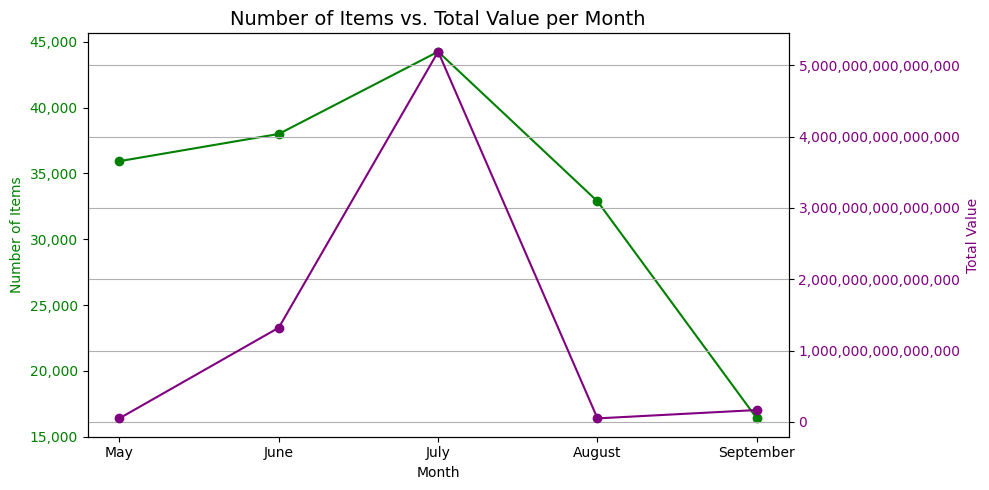

In [33]:
# Ensure date column is datetime
merged_dataset_cart['date'] = pd.to_datetime(merged_dataset_cart['date'])

# 1️⃣ Group by month → Count items
monthly_trend = (
    merged_dataset_cart
    .groupby(merged_dataset_cart['date'].dt.month)['itemid']
    .count()
)

# 2️⃣ Group by month → Sum real values
monthly_value_trend = (
    merged_dataset_cart
    .groupby(merged_dataset_cart['date'].dt.month)['Real_Values']
    .sum()
)

# Month mapping
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_trend.index = monthly_trend.index.map(month_map)
monthly_value_trend.index = monthly_value_trend.index.map(month_map)

# 📊 Plot both on the same graph
fig, ax1 = plt.subplots(figsize=(10, 5))

# First y-axis: Number of Items
ax1.plot(monthly_trend.index, monthly_trend.values, marker='o', color='green', label='Number of Items')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Items', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Second y-axis: Total Value
ax2 = ax1.twinx()
ax2.plot(monthly_value_trend.index, monthly_value_trend.values, marker='o', color='purple', label='Total Value')
ax2.set_ylabel('Total Value', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Title & Formatting
plt.title('Number of Items vs. Total Value per Month', fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()

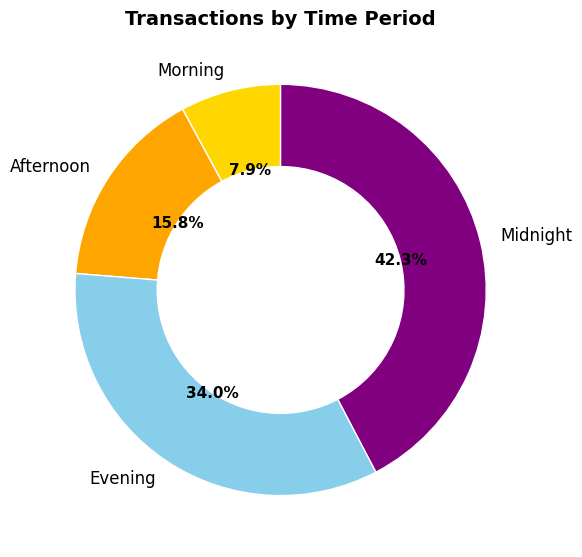

In [34]:
import matplotlib.pyplot as plt

# Count occurrences of each time period
time_counts = merged_dataset_cart['time_period'].value_counts().reindex(
    ['Morning', 'Afternoon', 'Evening', 'Midnight'],
    fill_value=0
)

# Colors
colors = ['gold', 'orange', 'skyblue', 'purple']

# Create donut plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    time_counts.values,
    labels=time_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'},
    textprops={'fontsize': 12}
)

# Style percentage labels
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_color('black')
    autotext.set_fontweight('bold')

plt.title('Transactions by Time Period', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## What is the number of items transacted over the days of the week?

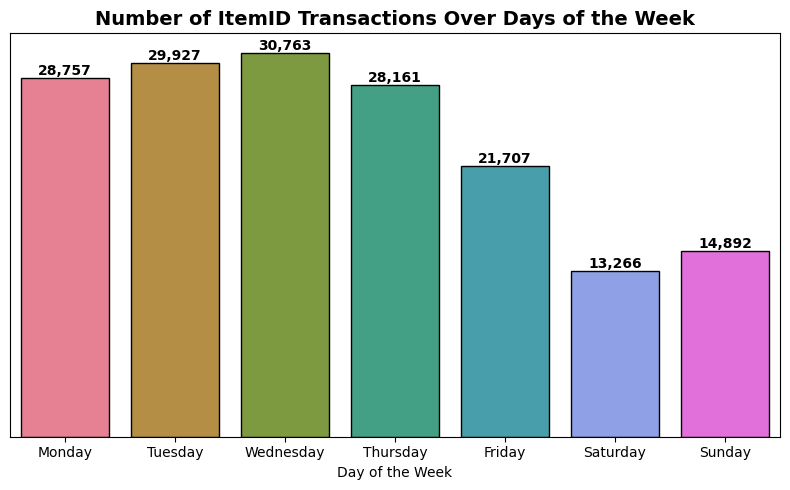

    day_name  item_count
0     Monday       28757
1    Tuesday       29927
2  Wednesday       30763
3   Thursday       28161
4     Friday       21707
5   Saturday       13266
6     Sunday       14892


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'date' is in datetime format
merged_dataset_cart['date'] = pd.to_datetime(merged_dataset_cart['date'], errors='coerce')

# Create numeric day_of_week (0=Mon, 6=Sun)
merged_dataset_cart['day_of_week'] = merged_dataset_cart['date'].dt.dayofweek

# Map numeric days to weekday names
day_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}
merged_dataset_cart['day_name'] = merged_dataset_cart['day_of_week'].map(day_map)

# Order days for plotting
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count number of itemid transactions per day
day_counts = (
    merged_dataset_cart.groupby('day_name')['itemid']
    .count()
    .reindex(order_days)
    .reset_index(name='item_count')
)

# Create distinct colors for each day
colors = sns.color_palette("husl", len(order_days))  # vibrant distinct colors

# Create bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='day_name',
    y='item_count',
    data=day_counts,
    order=order_days,
    palette=colors,
    edgecolor='black'
)

# Add data labels on bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()):,}",  # formatted with commas
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

# Remove y-axis ticks and label
ax.set_yticks([])
ax.set_ylabel('')

# Title & labels
plt.title('Number of ItemID Transactions Over Days of the Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of the Week')

plt.tight_layout()
plt.show()

# Print table for reference
print(day_counts)


#When are item usually bought (Month ending or Not)?

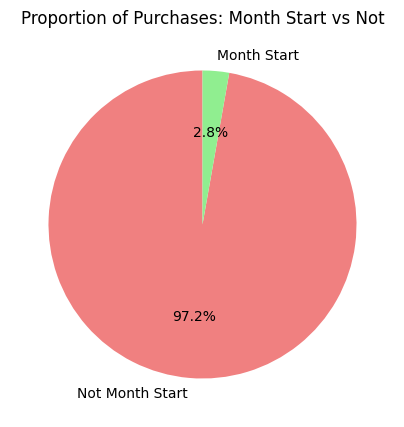

In [36]:
# Create month start column
merged_dataset_cart['is_month_start'] = merged_dataset_cart['date'].dt.is_month_start.astype(int)

# Ensure both 0 and 1 are present in the count
month_start_counts = merged_dataset_cart['is_month_start'].value_counts().reindex([0, 1], fill_value=0)

# Labels
labels = ['Not Month Start', 'Month Start']

# Create pie chart
plt.figure(figsize=(5,5))
plt.pie(
    month_start_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightcoral', 'lightgreen']
)

plt.title('Proportion of Purchases: Month Start vs Not')
plt.show()


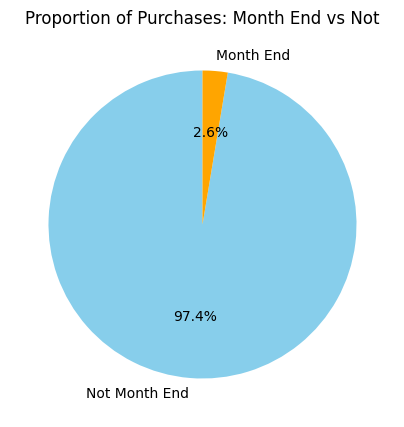

In [37]:
#Create a column of is month end
merged_dataset_cart['is_month_end'] = merged_dataset_cart['date'].dt.is_month_end.astype(int)

# Count occurrences (ensure both 0 and 1 exist)
month_end_counts = merged_dataset_cart['is_month_end'].value_counts().reindex([0, 1], fill_value=0)

# Labels
labels = ['Not Month End', 'Month End']

# Create pie chart
plt.figure(figsize=(5,5))
plt.pie(
    month_end_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'orange']
)

plt.title('Proportion of Purchases: Month End vs Not')
plt.show()

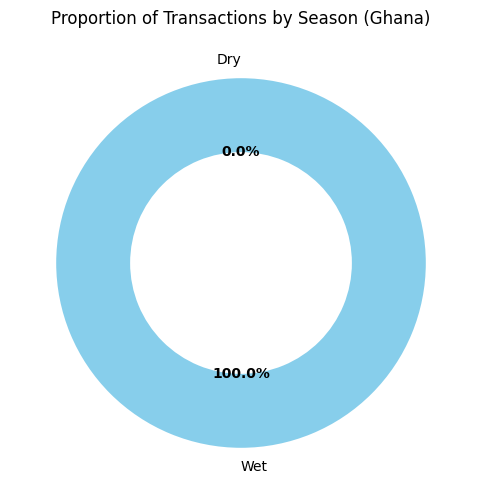

In [38]:
# Dry = Nov–Mar, Wet = Apr–Oct (Ghana)
merged_dataset_cart['season'] = merged_dataset_cart['month'].apply(lambda m: 'Dry' if m in [11, 12, 1, 2, 3] else 'Wet')

# Count occurrences (ensure Dry and Wet exist)
season_counts = merged_dataset_cart['season'].value_counts().reindex(['Dry', 'Wet'], fill_value=0)

# Create donut plot
plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['gold', 'skyblue'],
    wedgeprops=dict(width=0.4)  # makes it a donut
)

plt.setp(autotexts, size=10, weight="bold")
plt.title('Proportion of Transactions by Season (Ghana)')
plt.show()


##Data Processing

In [39]:
# Load dataset
events_df = pd.read_csv("events.csv")

# Convert timestamp to datetime
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"], unit="ms")

# Check first few rows
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [40]:
# Check for missing values
print("Missing values in item_properties_df:")
print(events_df.isnull().sum())



Missing values in item_properties_df:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


In [41]:
# Check for duplicates
print("\nDuplicate rows in events:", events_df.duplicated().sum())



Duplicate rows in events: 460


##Anomaly Detection (Detecting Bots in the data)

Aggregate User Activity


*   Compute the number of events per user
*   Compute the time span of user activity
*   Identify users with unusually high activity (potential bots)

In [42]:
#Convert to date format
# Convert timestamp to datetime
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms', errors='coerce')
#events['timestamp'] = pd.to_datetime(events['timestamp'], errors='coerce')

# Group by visitorid and compute the number of events per user
user_activity = events_df.groupby("visitorid").agg(
    event_count=("event", "count"),  # Total number of events
    first_event=("timestamp", "min"),  # First recorded event
    last_event=("timestamp", "max")   # Last recorded event
).reset_index()

# Compute session duration (time span of activity)
user_activity["session_duration"] = (user_activity["last_event"] - user_activity["first_event"]).dt.total_seconds()

# Display results
user_activity.head()

,visitorid,event_count,first_event,last_event,session_duration
0,0,3,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,327.736
1,1,1,2015-08-13 17:46:06.444,2015-08-13 17:46:06.444,0.000
2,2,8,2015-08-07 17:51:44.567,2015-08-07 18:20:57.845,1753.278
3,3,1,2015-08-01 07:10:35.296,2015-08-01 07:10:35.296,0.000
4,4,1,2015-09-15 21:24:27.167,2015-09-15 21:24:27.167,0.000


Detect & Remove Bots
*   Identify users with unusually high event counts
*   Identify users with very short session durations

Remove these users from merged_dataset.
Define Bot Detection Criteria:
*   Users with event counts in the top 1% (very high activity)
*   Users with session durations less than 1 second (too fast to be human)


In [43]:
#import dask.dataframe as dd
# Define thresholds for bot detection
event_threshold = user_activity["event_count"].quantile(0.99)  # Top 1% most active users
duration_threshold = 1  # Users with session duration < 1 second

# Identify bot users
bot_users = user_activity[
    (user_activity["event_count"] > event_threshold) |
    (user_activity["session_duration"] < duration_threshold)
]["visitorid"]

print(f"Identified {len(bot_users)} potential bots.")

# Remove bot users from the events dataset
events_df_cleaned = events_df[~events_df["visitorid"].isin(bot_users)]
print(f"Remaining users after bot removal: {events_df_cleaned['visitorid'].nunique()}")



Identified 1015778 potential bots.
Remaining users after bot removal: 391802


Recommendation System_FE
*   events.csv: Essential for user-item interactions.
*   item_properties_part1.1.csv & item_properties_part2.csv: Needed to map items to categories and properties.
*   category_tree.csv: Helps structure product categories for content-based recommendations.

##Extract Time-Based Features

In [44]:
# Load dataset
#events_df = dd.read_csv("cleaned_events.csv")
events_df = events_df_cleaned
# Convert `timestamp` column to datetime
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"], errors="coerce")

# Extract time-based features
events_df["hour"] = events_df["timestamp"].dt.hour
events_df["day_of_week"] = events_df["timestamp"].dt.dayofweek
events_df["month"] = events_df["timestamp"].dt.month


##Encode Categorical Features

In [45]:
events_df["event"] = events_df["event"].fillna("Unknown").astype(str)

event_encoder = LabelEncoder()
events_df["event_encoded"] = event_encoder.fit_transform(events_df["event"])

if "category_id" in events_df.columns:
    events_df["category_id"] = events_df["category_id"].astype("int64")

##Compute User Interaction Features

In [46]:
#events_df = pd.read_csv("events_encoded.csv")  # Pandas instead of Dask

# Ensure timestamp is datetime
events_df["timestamp"] = pd.to_datetime(events_df["timestamp"])

# Compute total number of events per user
events_df["total_events"] = events_df.groupby("visitorid")["event"].transform("count")

# Compute session count
events_df["session_count"] = events_df.groupby("visitorid")["timestamp"].transform("nunique")

# Sort by visitorid and timestamp
events_df = events_df.sort_values(["visitorid", "timestamp"])

# Compute time since last event
events_df["time_since_last_event"] = (
    events_df.groupby("visitorid")["timestamp"]
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

# Reorder columns
column_order = [
    "timestamp", "visitorid", "event", "itemid", "transactionid",
    "event_encoded", "day_of_week", "hour", "month",
    "total_events", "session_count", "time_since_last_event"
]
events_df = events_df[column_order]

print("\nUser interaction feature extraction complete!")


User interaction feature extraction complete!


In [47]:
import dask.dataframe as dd

# Ensure timestamp is in datetime format
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"])

# Sort values to ensure correct diff order
events_df = events_df.sort_values(["visitorid", "itemid", "timestamp"])

# Compute time difference directly with groupby and diff
events_df["time_spent"] = (
    events_df.groupby(["visitorid", "itemid"])["timestamp"]
    .diff()
    .dt.total_seconds()
    .fillna(0)
)

print("\nUser-item interaction features extracted!")



User-item interaction features extracted!


In [48]:
import pandas as pd
import dask.dataframe as dd

# Ensure events_df is a Dask DataFrame
if not isinstance(events_df, dd.DataFrame):
    events_df = dd.from_pandas(events_df, npartitions=4)

# Ensure timestamp is datetime
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"], errors="coerce")

# Aggregate user-level event counts and times
user_events = events_df.groupby("visitorid").agg({
    "timestamp": ["count", "min", "max"]
})

# Compute unique items
unique_items = events_df.groupby("visitorid")["itemid"].nunique()

# Bring everything into memory as Pandas
user_events = user_events.compute()
unique_items = unique_items.compute()

# Flatten MultiIndex column names
user_events.columns = ["event_count", "first_event", "last_event"]
user_activity = user_events.reset_index()

# Add unique items column
user_activity["unique_items"] = unique_items.values

# Convert timestamps
user_activity["first_event"] = pd.to_datetime(user_activity["first_event"])
user_activity["last_event"] = pd.to_datetime(user_activity["last_event"])

# Compute session duration in seconds
user_activity["session_duration"] = (
    user_activity["last_event"] - user_activity["first_event"]
).dt.total_seconds()

print("\n✅ User activity features extracted successfully!")



✅ User activity features extracted successfully!


In [49]:
print("User activity aggregation complete. Sample:")
print(user_activity.head())

User activity aggregation complete. Sample:
   visitorid  event_count             first_event              last_event  \
0     257597            2 2015-06-25 23:05:51.446 2015-06-25 23:42:03.336   
1     111016            2 2015-06-10 07:04:13.923 2015-06-10 10:34:10.246   
2     483717            3 2015-08-19 17:21:07.378 2015-08-19 17:57:28.509   
3     972639            2 2015-05-23 22:55:25.707 2015-05-23 23:11:25.291   
4     810725            2 2015-05-09 05:07:25.559 2015-05-09 05:30:35.234   

   unique_items  session_duration  
0             8          2171.890  
1             6         12596.323  
2             1          2181.131  
3             1           959.584  
4             1          1389.675  


###Modeling
Anomaly Detection Model

Detected 3919 anomalous users out of 391802 total users.


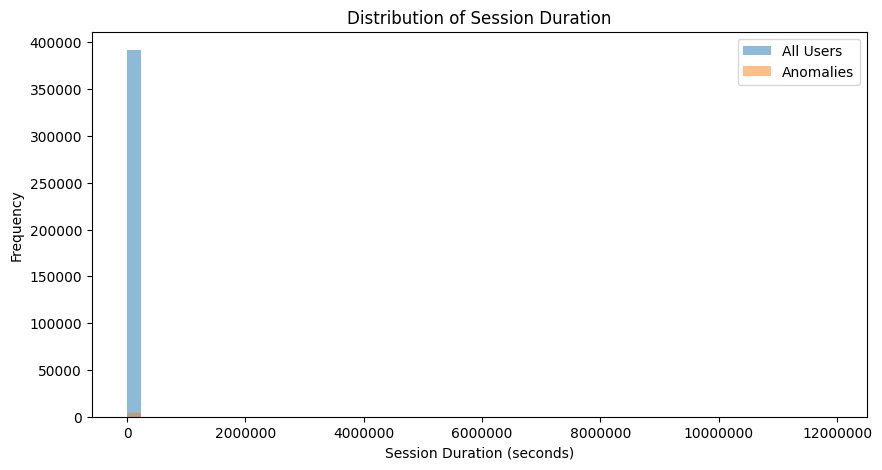

In [50]:
# Ensure timestamp columns are datetime
user_activity["first_event"] = pd.to_datetime(user_activity["first_event"])
user_activity["last_event"] = pd.to_datetime(user_activity["last_event"])

# Select relevant features
features = user_activity[["event_count", "session_duration", "unique_items"]]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
user_activity["anomaly"] = iso_forest.fit_predict(features)

# Extract anomalies
anomalies = user_activity[user_activity["anomaly"] == -1]
print(f"Detected {len(anomalies)} anomalous users out of {len(user_activity)} total users.")

# Plot distribution of session duration without scientific notation
plt.figure(figsize=(10, 5))
plt.hist(user_activity["session_duration"], bins=50, alpha=0.5, label="All Users")
plt.hist(anomalies["session_duration"], bins=50, alpha=0.5, label="Anomalies")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Session Duration")

# Force x-axis to use plain numbers (no scientific notation)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='x')

plt.show()


In [51]:
# Get a list of normal user IDs (anomaly label 1)
normal_users = user_activity[user_activity["anomaly"] == 1]["visitorid"].tolist()

events_df = events_df[events_df["visitorid"].isin(normal_users)]
#events_df = events_df.compute()
events_df.to_csv("cleaned_events_no_anomalies.csv", index=False)
print("Cleaned events (without anomalies) saved successfully!")

Cleaned events (without anomalies) saved successfully!


##Recommendation System Model

In [52]:

# --- Load your dataset ---
events_df = pd.read_csv("events.csv")

# Map event types to rating scores
event_score = {"view": 1, "addtocart": 3, "transaction": 5}
events_df["rating"] = events_df["event"].map(event_score)

# Get unique users and items
unique_users = events_df["visitorid"].unique()
unique_items = events_df["itemid"].unique()
print("Unique users:", len(unique_users))
print("Unique items:", len(unique_items))

# Create ID→index mappings
user2idx = {user: idx for idx, user in enumerate(unique_users)}
item2idx = {item: idx for idx, item in enumerate(unique_items)}
idx2item = {idx: item for item, idx in item2idx.items()}

# Map IDs to integer indices
events_df["user_idx"] = events_df["visitorid"].map(user2idx)
events_df["item_idx"] = events_df["itemid"].map(item2idx)

# Build sparse user–item matrix
rows = events_df["user_idx"].to_numpy()
cols = events_df["item_idx"].to_numpy()
data = events_df["rating"].to_numpy()

user_item_matrix = coo_matrix(
    (data, (rows, cols)),
    shape=(len(unique_users), len(unique_items))
)


Unique users: 1407580
Unique items: 235061


###Run SVD Model

In [53]:
# --- Train SVD ---
n_components = 50
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd_model.fit_transform(user_item_matrix)  # (num_users, n_components)
item_factors = svd_model.components_.T                   # (num_items, n_components)

print("SVD model trained.")
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)


SVD model trained.
User factors shape: (1407580, 50)
Item factors shape: (235061, 50)


In [54]:
# --- Recommendation Function ---
def recommend_items(user_idx, top_k=10):
    """Return top-k recommended item indices for a given user index."""
    scores = np.dot(item_factors, user_factors[user_idx])  # dot product of user & item latent vectors
    top_indices = np.argsort(scores)[::-1][:top_k]
    return top_indices


In [55]:
# --- Recommend Items with Item IDs ---
def recommend_items(user_idx, top_k=10, return_names=False):
    """
    Recommend top-k items for a given user index.

    Args:
        user_idx (int): User index in latent space.
        top_k (int): Number of recommendations.
        return_names (bool): If True, return item IDs/names instead of indices.

    Returns:
        list: Recommended item indices or IDs.
    """
    # Compute scores = user_vector dot item_vectors
    scores = np.dot(item_factors, user_factors[user_idx])

    # Get top-k items
    top_indices = np.argsort(scores)[::-1][:top_k]

    if return_names:
        # Map back indices → item IDs (or names if you have an item lookup DataFrame)
        idx2item = {v: k for k, v in item2idx.items()}  # reverse mapping
        return [idx2item[i] for i in top_indices]

    return top_indices


# --- Example: Recommend for a Random User ---
sample_user = np.random.choice(list(user2idx.values()))  # pick a random user index

print(" Recommended item indices:", recommend_items(sample_user, top_k=5))
print(" Recommended item IDs:", recommend_items(sample_user, top_k=5, return_names=True))


 Recommended item indices: [11180 38934   578   441 37713]
 Recommended item IDs: [np.int64(9877), np.int64(48030), np.int64(464731), np.int64(37029), np.int64(210002)]


## Predict and Evaluate SDV model

In [56]:
# --- Precision@K Evaluation ---
def precision_at_k(k=10, sample_users=100):
    """Compute average precision@k across a sample of users."""
    precisions = []
    sampled_users = np.random.choice(list(user2idx.values()), min(sample_users, len(user2idx)), replace=False)

    for user_idx in sampled_users:
        # Ground truth = items the user has transacted
        relevant_items = events_df[(events_df["user_idx"] == user_idx) & (events_df["event"] == "transaction")]["item_idx"].unique()
        if len(relevant_items) == 0:
            continue

        # Recommended items
        recommended = recommend_items(user_idx, top_k=k)

        # Compute precision
        hits = len(set(recommended) & set(relevant_items))
        precisions.append(hits / k)

    return np.mean(precisions) if precisions else 0.0


# --- Recall@K Evaluation ---
def recall_at_k(k=10, sample_users=100):
    """Compute average recall@k across a sample of users."""
    recalls = []
    sampled_users = np.random.choice(list(user2idx.values()), min(sample_users, len(user2idx)), replace=False)

    for user_idx in sampled_users:
        relevant_items = events_df[(events_df["user_idx"] == user_idx) & (events_df["event"] == "transaction")]["item_idx"].unique()
        if len(relevant_items) == 0:
            continue

        recommended = recommend_items(user_idx, top_k=k)

        hits = len(set(recommended) & set(relevant_items))
        recalls.append(hits / len(relevant_items))

    return np.mean(recalls) if recalls else 0.0


# --- F1@K Evaluation ---
def f1_at_k(k=10, sample_users=100):
    """Compute average F1@k across a sample of users."""
    f1_scores = []
    sampled_users = np.random.choice(list(user2idx.values()), min(sample_users, len(user2idx)), replace=False)

    for user_idx in sampled_users:
        relevant_items = events_df[(events_df["user_idx"] == user_idx) & (events_df["event"] == "transaction")]["item_idx"].unique()
        if len(relevant_items) == 0:
            continue

        recommended = recommend_items(user_idx, top_k=k)

        hits = len(set(recommended) & set(relevant_items))
        precision = hits / k if k > 0 else 0
        recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0

        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return np.mean(f1_scores) if f1_scores else 0.0


# --- Run Evaluations ---
precision_k10 = precision_at_k(k=10, sample_users=200)
recall_k10 = recall_at_k(k=10, sample_users=200)
f1_k10 = f1_at_k(k=10, sample_users=200)

print(f" Precision@10: {precision_k10:.4f}")
print(f" Recall@10: {recall_k10:.4f}")
print(f" F1@10: {f1_k10:.4f}")


 Precision@10: 0.0000
 Recall@10: 0.0000
 F1@10: 0.0000


###Saving the model

In [57]:
# --- Save Pickle Files ---
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)
with open("user_factors.pkl", "wb") as f:
    pickle.dump(user_factors, f)
with open("item_factors.pkl", "wb") as f:
    pickle.dump(item_factors, f)
with open("user2idx.pkl", "wb") as f:
    pickle.dump(user2idx, f)
with open("idx2item.pkl", "wb") as f:
    pickle.dump(idx2item, f)

##Save mapping for Easier Loading

In [58]:
# --- Save Mappings for Easier Loading ---
pd.DataFrame({"user_id": unique_users}).to_csv("unique_users.csv", index=False)
pd.DataFrame({"item_id": unique_items}).to_csv("unique_items.csv", index=False)

# Convert keys to str for JSON compatibility
user2idx_json = {str(k): int(v) for k, v in user2idx.items()}
idx2item_json = {int(k): str(v) for k, v in idx2item.items()}

with open("mappings.json", "w") as f:
    json.dump({"user2idx": user2idx_json, "idx2item": idx2item_json}, f)

print("✅ Model, mappings, and evaluation completed successfully!")

✅ Model, mappings, and evaluation completed successfully!


###Hybrid Model

In [59]:
# Load the merged item properties data (using one of your merged CSVs as an example)
item_content_df = merged_dataset[["itemid", "property"]].drop_duplicates()

# Count frequency of each property value
prop_counts = item_content_df["property"].value_counts()

# Choose the top N most frequent categories (such as, 100)
top_n = 100
top_properties = prop_counts.nlargest(top_n).index.tolist()

# Replace properties not in the top list with 'Other'
item_content_df["category"] = item_content_df["property"].apply(
    lambda x: x if x in top_properties else "Other"
)

# One-hot encode the reduced category column
item_onehot = pd.get_dummies(item_content_df["category"], prefix="cat")

# Combine with itemid to get a final item content features DataFrame
item_content_df = pd.concat([item_content_df[["itemid"]], item_onehot], axis=1)

print("Item content features shape:", item_content_df.shape)

Item content features shape: (649029, 102)


* Frequency Counting:
We count how many times each property occurs.

* Top N Selection:
We select only the top 100 most frequent property values. Adjust top_n based on your data and memory constraints.

* Labeling Others:
Values not in the top 100 are replaced by "Other", reducing the number of unique categories dramatically.

* One-Hot Encoding:
We perform one-hot encoding on the reduced set of categories. This should now produce a manageable number of columns (roughly 101 columns: 100 top categories + 1 for “Other”).

In [67]:
# HYBRID RECOMMENDER: Collaborative (SVD) + Content-Based
# -------------------------------------------------------
import pandas as pd
import numpy as np
import pickle
from scipy.sparse import coo_matrix, csr_matrix, hstack
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# 1) Load & prepare interactions
# -----------------------------
events_df = pd.read_csv("events.csv")

# Map implicit feedback to scores
event_score = {"view": 1, "addtocart": 3, "transaction": 5}
events_df["rating"] = events_df["event"].map(event_score).fillna(0).astype(float)

# Index mappings
unique_users = events_df["visitorid"].unique()
unique_items = events_df["itemid"].unique()
user2idx = {u: i for i, u in enumerate(unique_users)}
item2idx = {it: i for i, it in enumerate(unique_items)}
idx2item = {i: it for it, i in item2idx.items()}

events_df["user_idx"] = events_df["visitorid"].map(user2idx)
events_df["item_idx"] = events_df["itemid"].map(item2idx)

# Sparse user–item matrix (ratings)
rows = events_df["user_idx"].to_numpy()
cols = events_df["item_idx"].to_numpy()
data = events_df["rating"].to_numpy()
user_item_matrix = coo_matrix((data, (rows, cols)),
                              shape=(len(unique_users), len(unique_items))).tocsr()

# --------------------------------
# 2) Collaborative model (SVD)
# --------------------------------
n_components = 50
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd_model.fit_transform(user_item_matrix)     # (U, k)
item_factors = svd_model.components_.T                       # (I, k)

# --------------------------------
# 3) Content-based item embeddings
# --------------------------------
# Build an items frame with any available metadata
# We’ll aggregate on itemid and take first non-null value per column
candidate_cols = ["title", "name", "description", "category", "category_id", "brand", "price"]
available_cols = [c for c in candidate_cols if c in events_df.columns]
items_meta = (events_df[["itemid"] + available_cols]
              .drop_duplicates("itemid")
              .set_index("itemid")
              .sort_index())

# Create a single text column if any text fields exist
text_cols = [c for c in ["title", "name", "description"] if c in items_meta.columns]
if text_cols:
    items_meta["__text__"] = (
        items_meta[text_cols].astype(str).replace("nan", "").agg(" ".join, axis=1)
    )
else:
    items_meta["__text__"] = ""  # empty if no text

# Categorical & numeric cols
cat_cols = [c for c in ["category", "category_id", "brand"] if c in items_meta.columns]
num_cols = [c for c in ["price"] if c in items_meta.columns]

# Define transformers
transformers = []

# Text -> TF-IDF
if "__text__" in items_meta.columns and items_meta["__text__"].str.strip().any():
    transformers.append(("text", TfidfVectorizer(max_features=20000, ngram_range=(1, 2)),
                         "__text__"))

# Categorical -> OneHot
if cat_cols:
    transformers.append(("cat",
                         OneHotEncoder(handle_unknown="ignore", sparse=True),
                         cat_cols))

# Numeric -> Scaled
if num_cols:
    transformers.append(("num",
                         Pipeline([("scaler", StandardScaler(with_mean=False))]),
                         num_cols))

# If nothing is available, fall back to an identity (zero) vector
if not transformers:
    # Minimal all-zero features to keep shapes consistent
    item_content_matrix = csr_matrix((len(items_meta), 1))
else:
    # ColumnTransformer expects a 2D input; for text we’ll fit TF-IDF separately
    # Build sparse blocks and hstack them
    blocks = []
    # Text block
    if any(name == "text" for name, *_ in transformers):
        tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
        text_block = tfidf.fit_transform(items_meta["__text__"])
        blocks.append(text_block)
    # Categorical block
    if cat_cols:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)
        cat_block = ohe.fit_transform(items_meta[cat_cols])
        blocks.append(cat_block)
    # Numeric block
    if num_cols:
        # StandardScaler with sparse support: use mean=False
        scaler = StandardScaler(with_mean=False)
        # Convert to sparse numeric matrix
        num_block = csr_matrix(items_meta[num_cols].fillna(0).to_numpy(dtype=float))
        num_block = scaler.fit_transform(num_block)
        blocks.append(num_block)

    item_content_matrix = hstack(blocks).tocsr()

# Normalize item content vectors (for cosine similarity via dot product)
item_content_matrix = normalize(item_content_matrix, norm="l2", copy=False)

# Ensure item order corresponds to item2idx
# Reindex items_meta to match unique_items order
items_meta = items_meta.reindex(unique_items)
# Align content matrix rows to the same order
# (reindexing above already sorted by unique_items; make sure shapes match)
assert item_content_matrix.shape[0] == len(unique_items), "Item matrix row count mismatch."

# ---------------------------------------------------
# 4) Hybrid scoring: blend CF and content-based scores
# ---------------------------------------------------
def _minmax_scale(x):
    x = x.astype(float)
    x_min, x_max = np.min(x), np.max(x)
    if x_max - x_min < 1e-12:
        return np.zeros_like(x)
    return (x - x_min) / (x_max - x_min)

def recommend_hybrid_for_user(user_id, top_k=10, alpha=0.6, use_transactions_weight=True, exclude_seen=True):
    """
    Hybrid recommendation:
      score = alpha * CF_score + (1 - alpha) * Content_score

    alpha in [0,1] controls the weight of collaborative vs. content signals.
    """
    if user_id not in user2idx:
        # Cold-start user: return popular items (by total rating)
        popularity = np.asarray(user_item_matrix.sum(axis=0)).ravel()
        top_idx = np.argsort(popularity)[::-1][:top_k]
        return [idx2item[i] for i in top_idx]

    uidx = user2idx[user_id]

    # --- CF scores ---
    cf_scores = item_factors @ user_factors[uidx]  # shape (I,)
    cf_scores = _minmax_scale(cf_scores)

    # --- Content scores (user profile built from items they've interacted with) ---
    user_row = user_item_matrix.getrow(uidx)  # sparse row vector (1, I)
    item_indices = user_row.indices
    item_ratings = user_row.data

    if item_indices.size == 0:
        # No history → fallback to popularity
        popularity = np.asarray(user_item_matrix.sum(axis=0)).ravel()
        top_idx = np.argsort(popularity)[::-1][:top_k]
        return [idx2item[i] for i in top_idx]

    # Optionally weight only by "stronger" signals (e.g., transactions)
    if use_transactions_weight and "event" in events_df.columns:
        # Build weight vector per item index based on strongest interaction
        # (max rating seen for that user-item)
        user_interactions = events_df[events_df["user_idx"] == uidx]
        strength = (user_interactions
                    .groupby("item_idx")["rating"].max()
                    .reindex(item_indices).fillna(1.0).to_numpy())
        weights = strength
    else:
        weights = item_ratings  # use implicit rating sums

    # Build content-based user profile (weighted sum of item content vectors)
    # item_content_matrix[item_indices] -> (n_items_user, F)
    user_profile = weights @ item_content_matrix[item_indices, :]  # (F,)
    # Normalize profile
    denom = np.linalg.norm(user_profile) + 1e-12
    user_profile = user_profile / denom

    # Content score = cosine similarity between user profile and each item vector = dot product
    content_scores = item_content_matrix @ user_profile  # shape (I,)
    content_scores = _minmax_scale(content_scores)

    # Blend
    hybrid_scores = alpha * cf_scores + (1 - alpha) * content_scores

    # Optionally exclude items the user has already interacted with
    if exclude_seen:
        hybrid_scores[item_indices] = -np.inf

    top_indices = np.argsort(hybrid_scores)[::-1][:top_k]
    return [idx2item[i] for i in top_indices]

# ---------------------------------------------------
# 5) Quick demo: recommend for a random known user
# ---------------------------------------------------
sample_user = np.random.choice(unique_users)
print("Hybrid recommendations (item IDs):", recommend_hybrid_for_user(sample_user, top_k=10, alpha=0.6))

# ---------------------------------------------------
# 6) (Optional) Save models & artifacts
# ---------------------------------------------------
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)
with open("user_factors.pkl", "wb") as f:
    pickle.dump(user_factors, f)
with open("item_factors.pkl", "wb") as f:
    pickle.dump(item_factors, f)
with open("user2idx.pkl", "wb") as f:
    pickle.dump(user2idx, f)
with open("idx2item.pkl", "wb") as f:
    pickle.dump(idx2item, f)

# Save minimal content artifacts to rebuild content scoring later (optional)
# You can also persist TF-IDF, OHE, and scaler if you need exact reproducibility.


Hybrid recommendations (item IDs): [np.int64(29196), np.int64(294676), np.int64(172894), np.int64(318333), np.int64(166306), np.int64(89323), np.int64(257040), np.int64(310944), np.int64(148103), np.int64(283923)]


###Hybrid model evaluation

In [78]:
import numpy as np
import pandas as pd
import pickle

# --- Load Required Files from the Hybrid Model ---
with open("user_factors.pkl", "rb") as f:
    user_factors = pickle.load(f)
with open("item_factors.pkl", "rb") as f:
    item_factors = pickle.load(f)
with open("user2idx.pkl", "rb") as f:
    user2idx = pickle.load(f)
with open("idx2item.pkl", "rb") as f:
    idx2item = pickle.load(f)   # should be {matrix_index: itemid}

# If idx2item is accidentally itemid→index, invert it:
if not all(isinstance(k, int) for k in idx2item.keys()):
    idx2item = {v: k for k, v in idx2item.items()}

# Reload events_df for ground-truth evaluation
events_df = pd.read_csv("events.csv")
events_df["user_idx"] = events_df["visitorid"].map(user2idx)
events_df["item_idx"] = events_df["itemid"].map({v: k for k, v in idx2item.items()})
# Now item_idx matches matrix indices used in item_factors


# --- Recommendation Function (return actual item IDs) ---
def recommend_items(user_idx, top_k=10):
    scores = np.dot(item_factors, user_factors[user_idx])
    top_indices = np.argsort(scores)[::-1][:top_k]
    return [idx2item[i] for i in top_indices]  # return item IDs


# --- Precision@K ---
def precision_at_k(k=10, sample_users=100):
    precisions = []
    sampled_users = np.random.choice(
        list(user2idx.values()),
        min(sample_users, len(user2idx)),
        replace=False
    )

    for user_idx in sampled_users:
        relevant_items = events_df[
            (events_df["user_idx"] == user_idx) &
            (events_df["event"] == "transaction")
        ]["itemid"].unique()   # compare on item IDs

        if len(relevant_items) == 0:
            continue

        recommended = recommend_items(user_idx, top_k=k)
        hits = len(set(recommended) & set(relevant_items))
        precisions.append(hits / k)

    return np.mean(precisions) if precisions else 0.0


# --- Recall@K ---
def recall_at_k(k=10, sample_users=100):
    recalls = []
    sampled_users = np.random.choice(
        list(user2idx.values()),
        min(sample_users, len(user2idx)),
        replace=False
    )

    for user_idx in sampled_users:
        relevant_items = events_df[
            (events_df["user_idx"] == user_idx) &
            (events_df["event"] == "transaction")
        ]["itemid"].unique()

        if len(relevant_items) == 0:
            continue

        recommended = recommend_items(user_idx, top_k=k)
        hits = len(set(recommended) & set(relevant_items))
        recalls.append(hits / len(relevant_items))

    return np.mean(recalls) if recalls else 0.0


# --- F1@K ---
def f1_at_k(k=10, sample_users=100):
    f1_scores = []
    sampled_users = np.random.choice(
        list(user2idx.values()),
        min(sample_users, len(user2idx)),
        replace=False
    )

    for user_idx in sampled_users:
        relevant_items = events_df[
            (events_df["user_idx"] == user_idx) &
            (events_df["event"] == "transaction")
        ]["itemid"].unique()

        if len(relevant_items) == 0:
            continue

        recommended = recommend_items(user_idx, top_k=k)
        hits = len(set(recommended) & set(relevant_items))

        precision = hits / k if k > 0 else 0
        recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0

        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return np.mean(f1_scores) if f1_scores else 0.0


# --- Run Evaluations ---
if __name__ == "__main__":
    k = 10
    sample_users = 200

    precision_k10 = precision_at_k(k=k, sample_users=sample_users)
    recall_k10 = recall_at_k(k=k, sample_users=sample_users)
    f1_k10 = f1_at_k(k=k, sample_users=sample_users)

    print(f"📊 Hybrid Model Evaluation (Top-{k})")
    print(f"   Precision@{k}: {precision_k10:.4f}")
    print(f"   Recall@{k}:    {recall_k10:.4f}")


📊 Hybrid Model Evaluation (Top-10)
   Precision@10: 0.0333
   Recall@10:    0.0000


In [ ]:
# --- Save Pickle Files ---
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)
with open("user_factors.pkl", "wb") as f:
    pickle.dump(user_factors, f)
with open("item_factors.pkl", "wb") as f:
    pickle.dump(item_factors, f)
with open("user2idx.pkl", "wb") as f:
    pickle.dump(user2idx, f)
with open("idx2item.pkl", "wb") as f:
    pickle.dump(idx2item, f)